# DATA 37712 Final

# Testing data and env

In [ ]:
!pip install yfinance --upgrade --no-cache-dir



In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt



# API connetion test

[*********************100%***********************]  1 of 1 completed


Historical Stock Data for AMZN
Price           Close       High        Low       Open     Volume
Ticker           AMZN       AMZN       AMZN       AMZN       AMZN
Date                                                             
2019-01-02  76.956497  77.667999  73.046501  73.260002  159662000
2019-01-03  75.014000  76.900002  74.855499  76.000504  139512000
2019-01-04  78.769501  79.699997  75.915497  76.500000  183652000
2019-01-07  81.475502  81.727997  79.459503  80.115501  159864000
2019-01-08  82.829002  83.830498  80.830498  83.234497  177628000


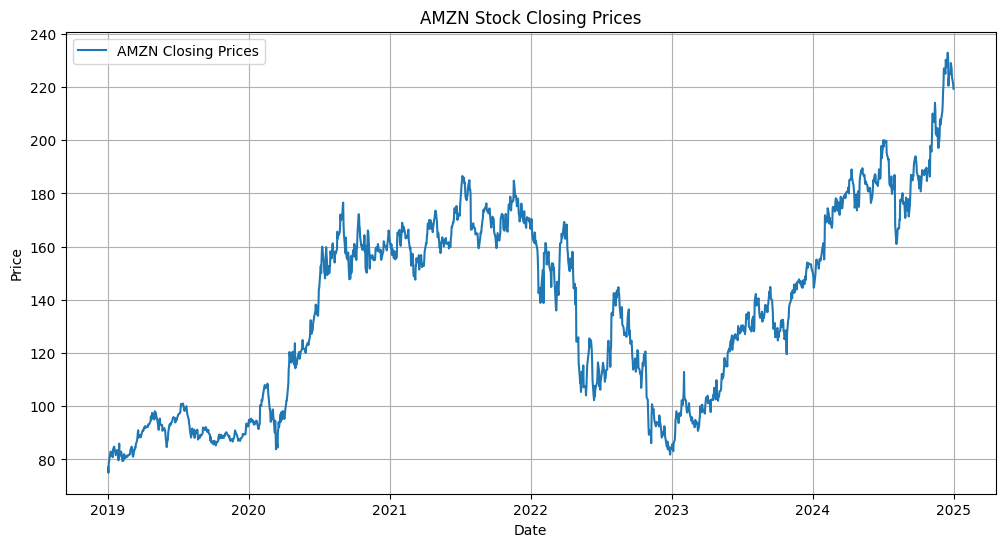

In [ ]:
# Set the stock ticker symbol (example: Apple Inc.)
ticker_symbol = "AMZN"

# Download historical stock data for the last 5 years
data = yf.download(ticker_symbol, start="2019-01-01", end="2025-01-01", auto_adjust=True)

# Display the first few rows of the data
print("Historical Stock Data for", ticker_symbol)
print(data.head())

# Plot the stock's closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label=f'{ticker_symbol} Closing Prices')
plt.title(f'{ticker_symbol} Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [ ]:
correlation_matrix = data.corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
Price             Close      High       Low      Open    Volume
Ticker             AMZN      AMZN      AMZN      AMZN      AMZN
Price  Ticker                                                  
Close  AMZN    1.000000  0.999123  0.999151  0.998064 -0.312088
High   AMZN    0.999123  1.000000  0.998946  0.999213 -0.300475
Low    AMZN    0.999151  0.998946  1.000000  0.999089 -0.324214
Open   AMZN    0.998064  0.999213  0.999089  1.000000 -0.311774
Volume AMZN   -0.312088 -0.300475 -0.324214 -0.311774  1.000000


# load data

In [ ]:
def load_stock_price(ticker: str, start_date: str = '2015-01-01', end_date: str = '2025-01-01'):
    '''
    input:
        tickers, single string of a ticker, like "AAPL"
        start_date: data start
        end_date: data end
    output:

    '''

    # Load Close price and Volume together
    data = yf.download(ticker, start_date, end_date)[['Close', 'Volume']]

    # Fill any missing values if needed
    data = data.ffill()

    # Split into train, validation, and test sets
    train_size = int(len(data) * 0.8)
    val_size = int(len(data) * 0.10)

    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]

    return train_data, val_data, test_data


# Scaling
- a min-max scaler is used for feature normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def scaling(train_data, val_data , test_data):
    """
    Scales the data using MinMaxScaler and returns scaled data and the scaler.

    Args:
        train_data (np.ndarray): Training data array.
        val_data (np.ndarray): Validation data array.
        test_data (np.ndarray): Test data array.

    Returns:
        tuple: Scaled train, validation, and test datasets along with the scaler instance.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_train_data = scaler.fit_transform(train_data)
    scaled_val_data = scaler.transform(val_data)
    scaled_test_data = scaler.transform(test_data)

    return scaled_train_data, scaled_val_data, scaled_test_data, scaler

def inverse_scaling(scaler, predicted_prices, test_labels):
    """
    Inverse transforms the predicted prices and test labels using the given scaler.

    Args:
        scaler (MinMaxScaler): Fitted MinMaxScaler instance.
        predicted_prices (list): List of predicted prices from the model.
        test_labels (torch.Tensor): Ground truth labels from the test set.

    Returns:
        tuple: Inverse-transformed predicted and actual prices.
    """

    # Reshape predicted prices to match scaler's input format
    predicted_prices = np.array(predicted_prices).reshape(-1, 1)
    # Create a dummy array with both price and volume
    dummy_input = np.zeros((predicted_prices.shape[0], 2))
    dummy_input[:, 0] = predicted_prices[:, 0]  # Populate the price column
    # Inverse transform
    predicted_prices = scaler.inverse_transform(dummy_input)[:, 0]  # Extract only the price

    # Inverse transform the actual test labels
    test_labels_reshaped = test_labels.cpu().numpy().reshape(-1, 1)
    dummy_actual = np.zeros((test_labels_reshaped.shape[0], 2))
    dummy_actual[:, 0] = test_labels_reshaped[:, 0]

    actual_prices = scaler.inverse_transform(dummy_actual)[:, 0]

    return predicted_prices, actual_prices

# Performance evaluation
- Mean Absolute Error (MAE) and Mean Suqare Error(MSE) are most conceivable metric, which measures the average magnitude of the errors between predicted and actual stock prices without considering their direction.
- Since MAE is affected by the magnitude of targets, the second, Mean Absolute Percentage Error (MAPE) is also going to be used to provide insights into how well the model adapts to fluctuations in stock prices.

In [ ]:

def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # Avoid division by zero by filtering out zeros
    non_zero_indices = y_true != 0
    mape = np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100
    return mape

def evaluation(actual_prices, predicted_prices):

    mse = np.mean((np.array(predicted_prices) - np.array(actual_prices)) ** 2)
    mae = np.mean(abs(np.array(predicted_prices) - np.array(actual_prices)))
    mape = mean_absolute_percentage_error(actual_prices, predicted_prices)

    return mse, mae, mape

# A simple LSTM model to predict stock price
- After analysis the correlations between variable, we found that daily open, close, high, and highly correlated. At the end of the day, we decided to choose two variables -- close and volumn, to predict the price stock price of next trainding day.
- The LSTM model use a sequence length of 40 to 60(trading days), which corresponds to roughly two months to three months.
- To mitigate overfitting, AdamW is chosen as optimizer.
- possible improvement: consider date-related strategy, add date variables
    - End-of-Month (EOM) Effect: Stocks tend to rise at the end of the month due to portfolio adjustments.
    - Turn-of-the-Month Effect: Stocks historically perform well in the last few days of a month and the first few days of the next.
    - Day-of-the-Week Effect: Some stocks show patterns like the Monday Effect.


[*********************100%***********************]  1 of 1 completed


Epoch: 0    Train Loss: 0.0370
Epoch: 0    Val Loss: 0.0035
Update the best!
Update the best!
Update the best!
Update the best!
Update the best!
Update the best!
Update the best!
Epoch: 10    Train Loss: 0.0004
Epoch: 10    Val Loss: 0.0005
Update the best!
Update the best!
Epoch: 20    Train Loss: 0.0003
Epoch: 20    Val Loss: 0.0003
Update the best!
Update the best!
Epoch: 30    Train Loss: 0.0002
Epoch: 30    Val Loss: 0.0006
Update the best!
Update the best!
Epoch: 40    Train Loss: 0.0002
Epoch: 40    Val Loss: 0.0019
Update the best!
Epoch: 50    Train Loss: 0.0003
Epoch: 50    Val Loss: 0.0006
Update the best!
Update the best!
Epoch: 60    Train Loss: 0.0002
Epoch: 60    Val Loss: 0.0005
Early stopped!
Loaded the best model state.
LSTM predction of ^GSPC: MSE = 3939.03, MAE = 53.21, MAPE = 0.95


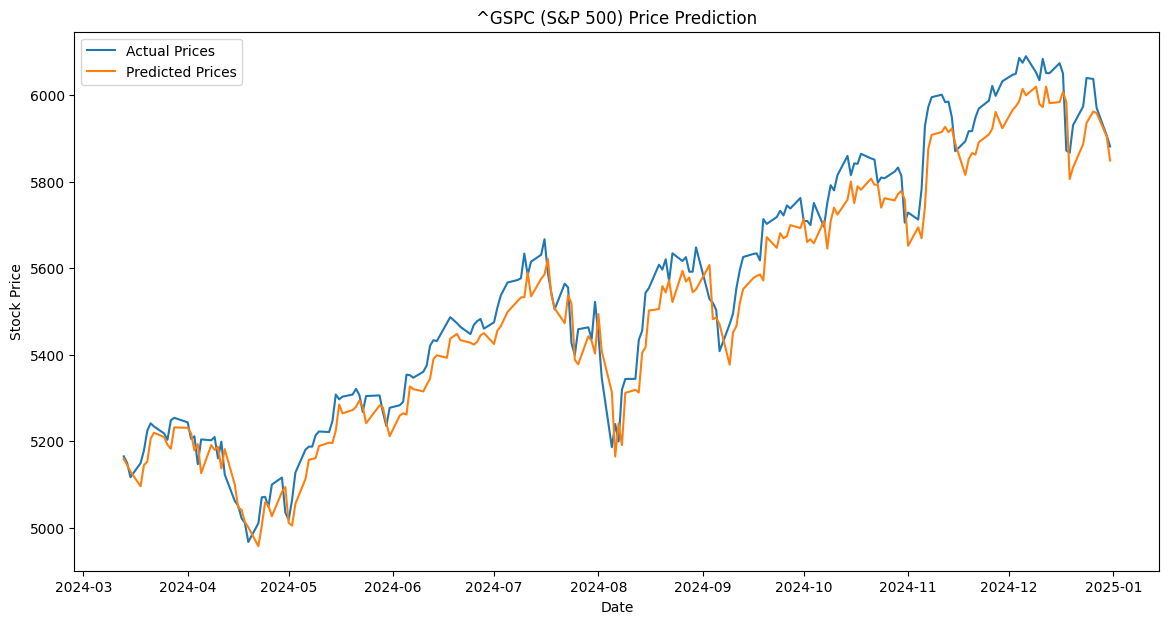

In [ ]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import copy
import random

import matplotlib.pyplot as plt


def set_random_seed(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)



DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(MyLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # initialize hidden state: (num_layers * num_directions, batch_size, hidden_size)
        # initialize cell state: (num_layers * num_directions, batch_size, hidden_size)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # input x : (batch_size, seq_length, input_size)
        lstm_out, _ = self.lstm(x, (h_0, c_0))  # (batch_size, seq_length, hidden_size)
        out = self.fc(lstm_out[:, -1, :])  # using the last state in seq_length
        return out

def create_sequences(data: np.ndarray, seq_length: int):
    """
    Create sequences with multiple features and labels for one feature.

    Parameters:
    - data: 2D numpy array of shape (num_samples, num_features)
    - seq_length: Length of each sequence

    Returns:
    - sequences: Numpy array of shape (num_sequences, seq_length, num_features)
    - labels: Numpy array of shape (num_sequences,)
    """
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length, 0])  # Only target price (first feature)
    return np.array(sequences), np.array(labels)



class EarlyStopper:
    def __init__(self, patience: int = 5, min_delta: float = 0.0):
        """
        Early stopping utility to stop training when validation loss stops improving.

        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def should_stop(self, val_loss: float) -> bool:
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience



def main():

    ticker = "^GSPC"
    train_data, val_data, test_data = load_stock_price(ticker)
    scaled_train_data, scaled_val_data, scaled_test_data, scaler = scaling(train_data, val_data, test_data)


    seq_length = 50  # Example sequence length

    train_sequences, train_labels = create_sequences(scaled_train_data, seq_length)
    val_sequences, val_labels = create_sequences(scaled_val_data, seq_length)
    test_sequences, test_labels = create_sequences(scaled_test_data, seq_length)

    # Convert numpy arrays to PyTorch tensors
    train_sequences = torch.tensor(train_sequences, dtype = torch.float32)
    train_labels = torch.tensor(train_labels, dtype = torch.float32)
    val_sequences = torch.tensor(val_sequences, dtype = torch.float32)
    val_labels = torch.tensor(val_labels, dtype = torch.float32)
    test_sequences = torch.tensor(test_sequences, dtype = torch.float32)
    test_labels = torch.tensor(test_labels, dtype = torch.float32)


    # DataLoader for batching
    batch_size = 64
    train_dataset = TensorDataset(train_sequences, train_labels)
    val_dataset = TensorDataset(val_sequences, val_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



    input_size = train_sequences.shape[2]
    hidden_size = 64
    num_layers = 2
    output_size = 1

    model = MyLSTM(input_size, hidden_size, output_size, num_layers).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-3)

    # Train the model
    epochs = 100

    early_stopper = EarlyStopper(patience = 10)
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)

            outputs = model(X_train)
            loss = criterion(outputs.squeeze(), y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}    Train Loss: {avg_train_loss:.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(DEVICE), y_val.to(DEVICE)

                outputs = model(X_val)
                loss = criterion(outputs.squeeze(), y_val)

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            if epoch % 10 == 0:
                print(f"Epoch: {epoch}    Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            print(f"Update the best!")
        if early_stopper.should_stop(avg_val_loss):
            print(f"Early stopped!")
            break
    if best_model_state:
        model.load_state_dict(best_model_state)
        model.to(DEVICE)
        print("Loaded the best model state.")

    # Evaluate the model on test data
    model.eval()

    # Collect predictions on the test set
    predicted_prices = []


    with torch.no_grad():
        for i in range(0, len(test_sequences), batch_size):
            X_test = test_sequences[i:i + batch_size].to(DEVICE)
            batch_outputs = model(X_test).cpu().numpy()
            predicted_prices.extend(batch_outputs.flatten())

    predicted_prices, actual_prices = inverse_scaling(scaler, predicted_prices, test_labels)

    ## Evaluation
    mse, mae, mape = evaluation(actual_prices, predicted_prices)
    print(f'LSTM predction of {ticker}: MSE = {mse:.2f}, MAE = {mae:.2f}, MAPE = {mape:.2f}')


    # Plot the test results
    plt.figure(figsize=(14, 7))
    plt.plot(test_data.index[seq_length:], actual_prices, label='Actual Prices')
    plt.plot(test_data.index[seq_length:], predicted_prices, label='Predicted Prices')
    plt.title(f'{ticker} (S&P 500) Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


if __name__ == "__main__":
    main()



# TFT from scratch ( don't run, not finished)

In [ ]:
class myTemporalFusionTransformer(nn.Module):
    def __init__(self,
                 input_size,        # Number of input features (including time-varying, static, etc.)
                 hidden_size,       # Hidden state size for attention and LSTM
                 num_heads,         # Number of attention heads
                 num_layers,        # Number of LSTM layers or transformer layers
                 dropout=0.1,       # Dropout rate
                 output_size=1,     # The output size (e.g., 1 for stock price prediction)
                 context_length=30, # The look-back window (N for N-day forecasting)
                 prediction_length=7): # How many steps to predict (e.g., 7 days ahead)
        super(TemporalFusionTransformer, self).__init__()

        # 1. Input Embedding Layers
        self.embedding = nn.Linear(input_size, hidden_size)

        # 2. Variable Selection Network (VSN) for feature selection
        self.variable_selection = nn.Linear(hidden_size, hidden_size)

        # 3. Temporal Convolutional Network (TCN)
        self.tcn = nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, padding=1)

        # 4. Multi-Head Attention (Self-Attention)
        self.multihead_attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads, dropout=dropout)

        # 5. Gating Mechanism (to choose which features to keep)
        self.gating = nn.Sigmoid()

        # 6. LSTM (optional, can be skipped if using only attention)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)

        # 7. Decoder Layer (to produce output)
        self.decoder = nn.Linear(hidden_size, output_size)

        # 8. Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, static_features=None):
        """
        Forward pass through the network.

        Args:
            x: Time-varying input sequence (batch_size, sequence_length, num_features)
            static_features: Static features that may be used (e.g., stock ticker embeddings)

        Returns:
            Output predictions for the next `prediction_length` time steps
        """
        # Step 1: Embedding the input data
        x = self.embedding(x)

        # Step 2: Variable Selection Network (VSN)
        x = self.variable_selection(x)

        # Step 3: Temporal Convolutional Network (TCN)
        x = self.tcn(x.transpose(1, 2)).transpose(1, 2)  # TCN expects (batch_size, channels, time_steps)

        # Step 4: Multi-Head Attention
        attn_output, _ = self.multihead_attention(x, x, x)  # Self-attention

        # Step 5: Apply the gating mechanism
        gated_output = self.gating(attn_output) * attn_output

        # Step 6: Use LSTM (optional)
        lstm_out, (h, c) = self.lstm(gated_output)  # batch_first=True

        # Step 7: Decoder Layer
        output = self.decoder(lstm_out[:, -1, :])  # Use the last time step's output

        return output



In [ ]:
from pytorch_forecasting.data import TimeSeriesDataSet

# Assume `df` is your dataframe with time series data for stock prices
# Create a TimeSeriesDataSet for TFT

max_encoder_length = 30  # Last 30 days of data for prediction
max_prediction_length = 7  # Predict next 7 days

# Define the dataset
training = TimeSeriesDataSet(
    df[lambda x: x.date <= '2020-01-01'],
    time_idx="time_idx",
    target="close",  # Target is the closing stock price
    group_ids=["stock_id"],  # Group by stock ticker ID (static feature)
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["stock_id"],  # Categorical features (stock symbol)
    time_varying_known_categoricals=["day_of_week", "month"],  # Day of the week, month
    time_varying_known_reals=["open", "high", "low", "volume"],  # Technical indicators, volume
    time_varying_unknown_reals=["close"],  # Target (closing price)
    target_normalizer=GroupNormalizer(groups=["stock_id"], transformation="softplus"),
)

